# Churn (attrition) de clients Telecom

On veut prédire le départ de clients d'un opérateur telecom à partir de données comme la formule d'abonnement, ou le temps de communication consommé.

On peut trouver le dataset sur :  
https://www.kaggle.com/mnassrib/telecom-churn-datasets


## Librairies et fonctions utiles

In [2]:
# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from IPython.core.display import HTML # permet d'afficher du code html dans jupyter

Fonction pour standardiser les données quantitatives (cont_feat est une liste des colonnes correspondant à des caractéristiques quantitatives) :

In [3]:
def scale_feat(df,cont_feat) :
    df1=df
    scaler = preprocessing.RobustScaler()
    df1[cont_feat] = scaler.fit_transform(df1[cont_feat])
    return df1

Fonction pour tracer les courbes d'apprentissage sur l'ensemble d'apprentissage et l'ensemble de validation :

In [40]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=est, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(visible=True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.show()

Fonction pour tracer la courbe ROC :

In [5]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
    plt.plot([0,0,1],[0,1,1],'g:')     # meilleure courbe
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

## Traitement du dataset

In [7]:
df = pd.read_csv("/content/churn-bigml-20.csv")

In [8]:
df.count()

,0
State,667
Account length,667
Area code,667
International plan,667
Voice mail plan,667
Number vmail messages,667
Total day minutes,667
Total day calls,667
Total day charge,667
Total eve minutes,667


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    fl

In [10]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,102.841079,436.157421,8.407796,180.948126,100.937031,30.761769,203.355322,100.476762,17.285262,199.685307,100.113943,8.985907,10.238381,4.527736,2.764948,1.563718
std,40.819480,41.783305,13.994480,55.508628,20.396790,9.436463,49.719268,18.948262,4.226160,49.759931,20.172505,2.239429,2.807850,2.482442,0.758167,1.333357
min,1.000000,408.000000,0.000000,25.900000,30.000000,4.400000,48.100000,37.000000,4.090000,23.200000,42.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,76.000000,408.000000,0.000000,146.250000,87.500000,24.860000,171.050000,88.000000,14.540000,167.950000,86.000000,7.560000,8.600000,3.000000,2.320000,1.000000
50%,102.000000,415.000000,0.000000,178.300000,101.000000,30.310000,203.700000,101.000000,17.310000,201.600000,100.000000,9.070000,10.500000,4.000000,2.840000,1.000000
75%,128.000000,415.000000,20.000000,220.700000,115.000000,37.520000,236.450000,113.000000,20.095000,231.500000,113.500000,10.420000,12.050000,6.000000,3.255000,2.000000
max,232.000000,510.000000,51.000000,334.300000,165.000000,56.830000,361.800000,168.000000,30.750000,367.700000,175.000000,16.550000,18.300000,18.000000,4.940000,8.000000


On mappe les valeurs de la colonne cible en 0/1 :

In [11]:
df['Churn'] = df['Churn'].map({ False: 0, True: 1 })

In [12]:
df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [13]:
discr_feat = ['State', 'International plan', 'Voice mail plan', 'Customer service calls','Area code', 'Number vmail messages']
cont_feat = list(set(df.columns) - set(discr_feat)-{'Churn'})

On convertit les catégories en étiquettes numériques :

In [14]:
for col in discr_feat :
    df[col]=df[col].astype('category')
    df[col] = df[col].cat.codes
    df[col]=df[col].astype('int8')


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    int8   
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int8   
 3   International plan      667 non-null    int8   
 4   Voice mail plan         667 non-null    int8   
 5   Number vmail messages   667 non-null    int8   
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    fl

In [16]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,18,117,0,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0
1,15,65,1,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1
2,34,161,1,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1
3,40,111,1,0,0,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,0
4,11,49,2,0,0,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,0


On vérifie s'il y a des valeurs indéterminées dans le dataset :

In [17]:
df.isnull().values.sum()

np.int64(0)

Les valeurs numériques ont des caractéristiques très différentes :

In [18]:
df[cont_feat].describe()

,Total intl charge,Total day minutes,Total intl calls,Total night charge,Total eve charge,Total eve calls,Total day charge,Total eve minutes,Total night minutes,Total night calls,Total day calls,Total intl minutes,Account length
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,2.764948,180.948126,4.527736,8.985907,17.285262,100.476762,30.761769,203.355322,199.685307,100.113943,100.937031,10.238381,102.841079
std,0.758167,55.508628,2.482442,2.239429,4.226160,18.948262,9.436463,49.719268,49.759931,20.172505,20.396790,2.807850,40.819480
min,0.000000,25.900000,0.000000,1.040000,4.090000,37.000000,4.400000,48.100000,23.200000,42.000000,30.000000,0.000000,1.000000
25%,2.320000,146.250000,3.000000,7.560000,14.540000,88.000000,24.860000,171.050000,167.950000,86.000000,87.500000,8.600000,76.000000
50%,2.840000,178.300000,4.000000,9.070000,17.310000,101.000000,30.310000,203.700000,201.600000,100.000000,101.000000,10.500000,102.000000
75%,3.255000,220.700000,6.000000,10.420000,20.095000,113.000000,37.520000,236.450000,231.500000,113.500000,115.000000,12.050000,128.000000
max,4.940000,334.300000,18.000000,16.550000,30.750000,168.000000,56.830000,361.800000,367.700000,175.000000,165.000000,18.300000,232.000000


On normalise ces valeurs :

In [19]:
df=scale_feat(df,cont_feat)

In [20]:
df[cont_feat].describe()

,Total intl charge,Total day minutes,Total intl calls,Total night charge,Total eve charge,Total eve calls,Total day charge,Total eve minutes,Total night minutes,Total night calls,Total day calls,Total intl minutes,Account length
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.00000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,-0.080270,0.035569,0.175912,-0.029403,-0.004453,-0.02093,0.035685,-0.005270,-0.030129,0.004143,-0.002290,-0.075832,0.016175
std,0.810874,0.745583,0.827481,0.783017,0.760785,0.75793,0.745376,0.760233,0.783004,0.733546,0.741701,0.813869,0.784990
min,-3.037433,-2.047011,-1.333333,-2.807692,-2.379838,-2.56000,-2.046603,-2.379205,-2.807238,-2.109091,-2.581818,-3.043478,-1.942308
25%,-0.556150,-0.430490,-0.333333,-0.527972,-0.498650,-0.52000,-0.430490,-0.499235,-0.529504,-0.509091,-0.490909,-0.550725,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.443850,0.569510,0.666667,0.472028,0.501350,0.48000,0.569510,0.500765,0.470496,0.490909,0.509091,0.449275,0.500000
max,2.245989,2.095366,4.666667,2.615385,2.419442,2.68000,2.094787,2.417431,2.613690,2.727273,2.327273,2.260870,2.500000


On affiche les distributions des valeurs continues :

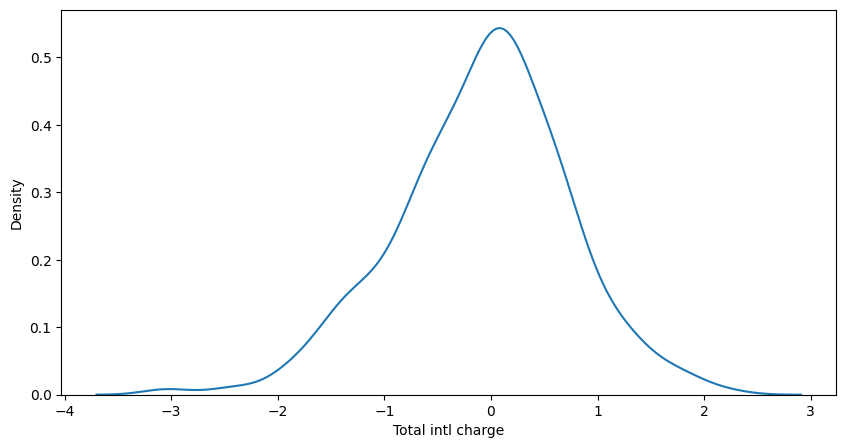

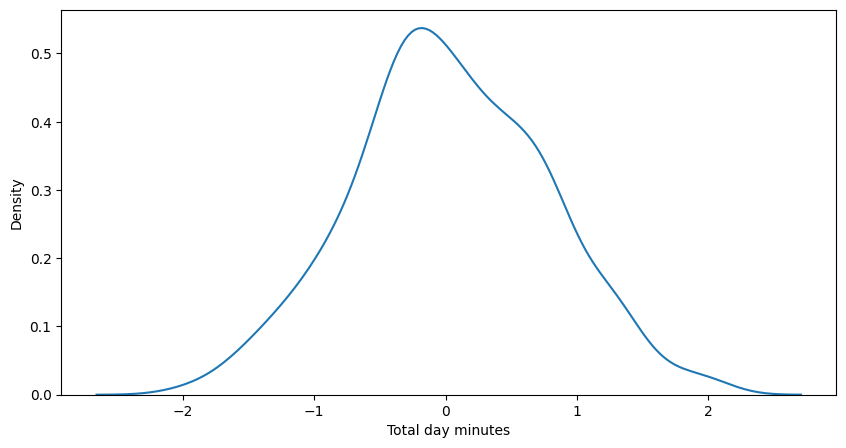

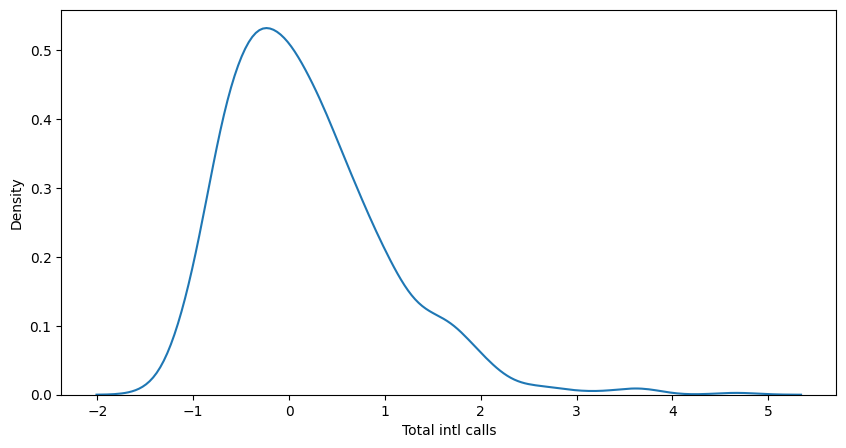

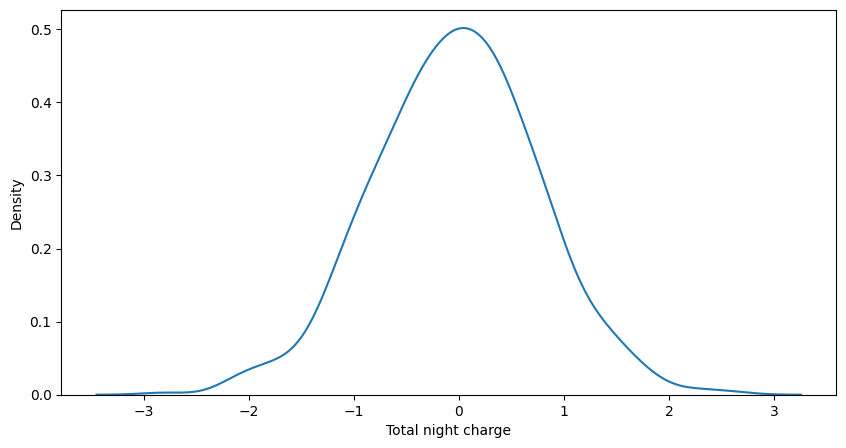

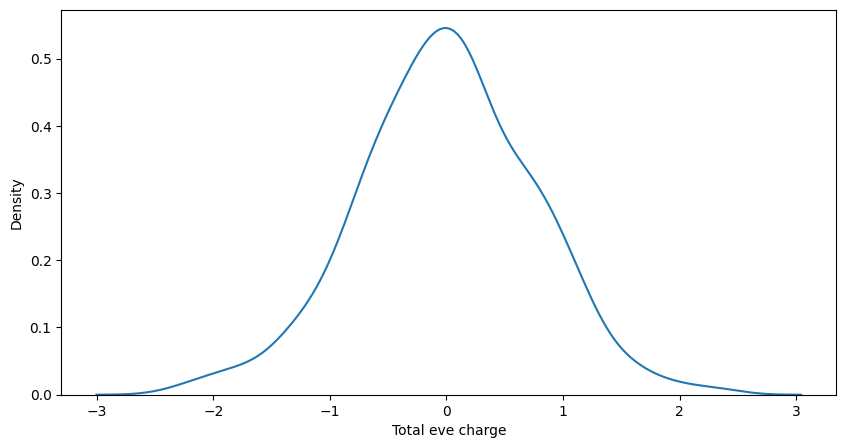

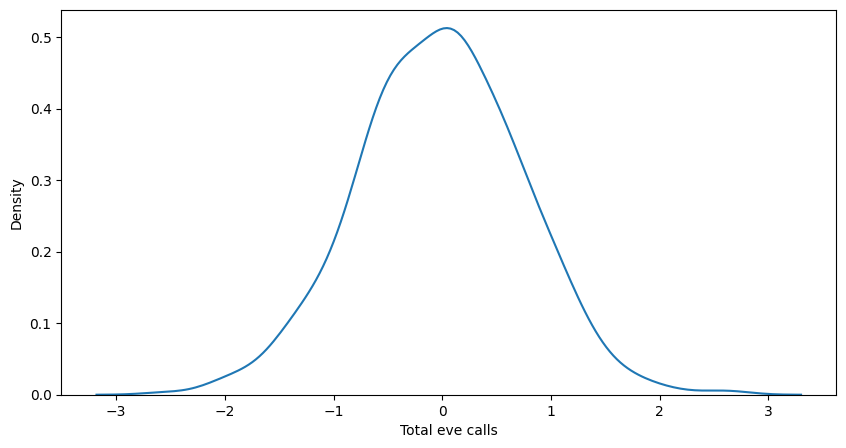

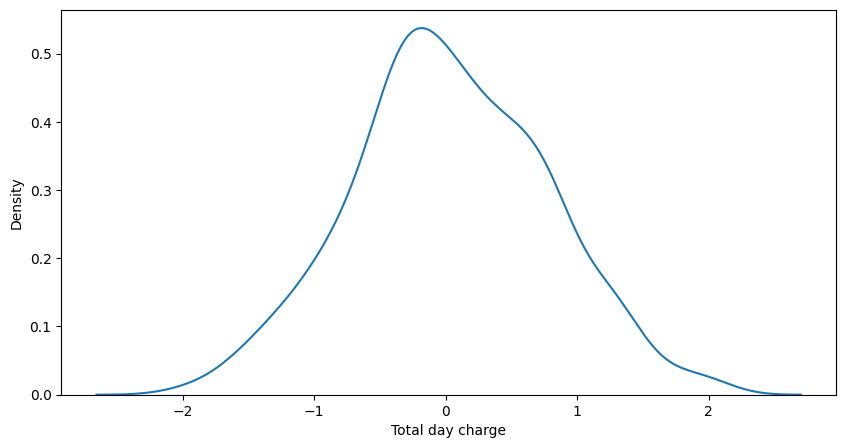

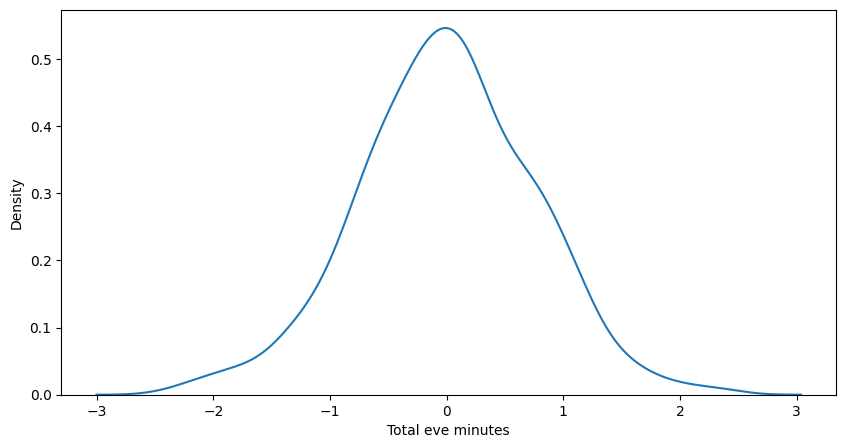

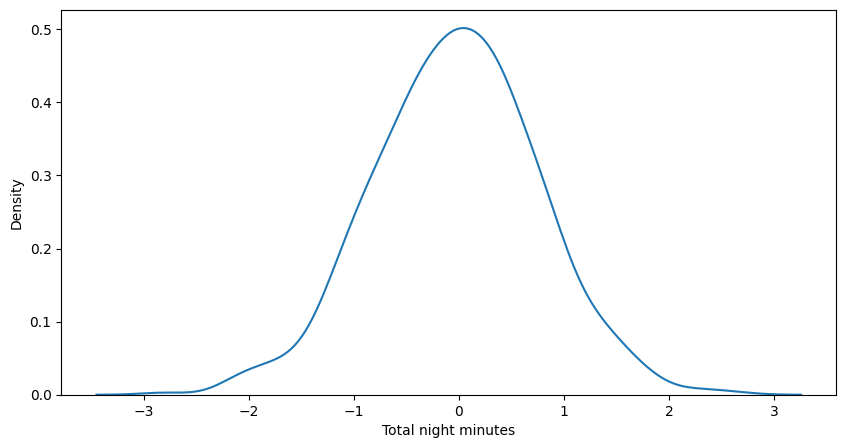

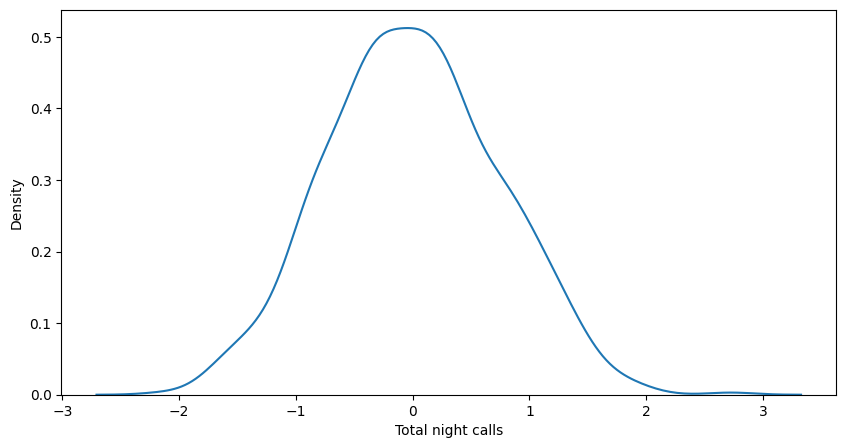

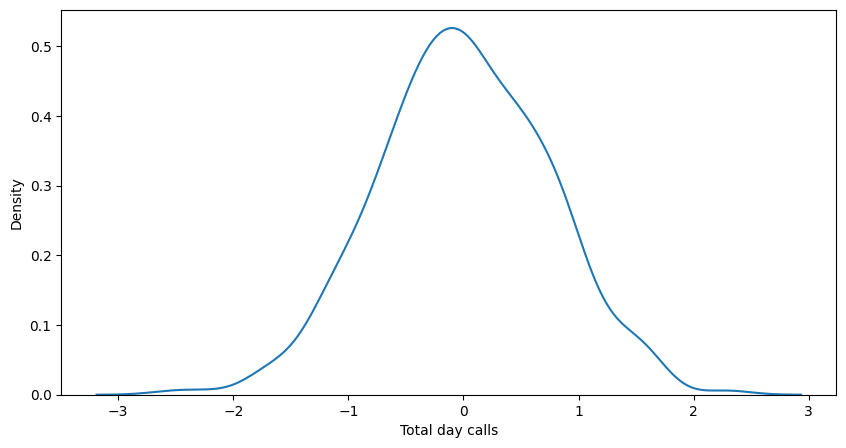

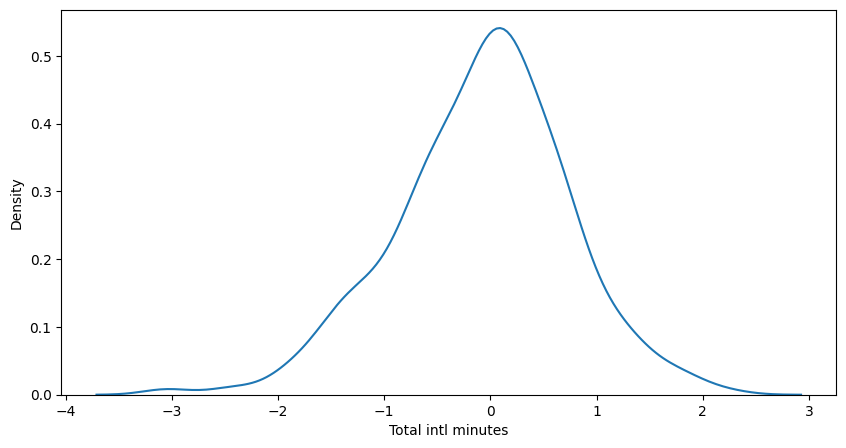

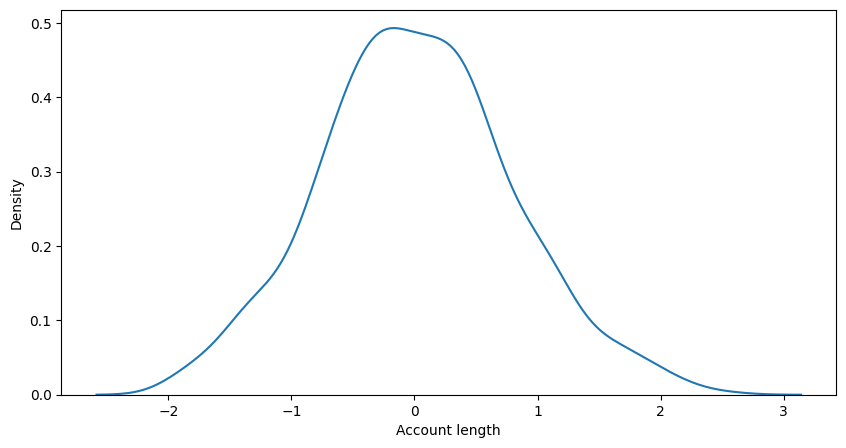

In [21]:
for col in cont_feat :
    plt.figure(figsize=[10,5])
    sns.kdeplot(df[col])

Est-il nécessaire d'appliquer une transformation sur les distributions ?

## Forêts aléatoires

On construit les ensembles d'apprentissage et de test :

In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(['Churn'], axis=1)
y = df.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

On teste les forêts aléatoires :

In [23]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

In [24]:
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       117
           1       0.67      0.59      0.62        17

    accuracy                           0.91       134
   macro avg       0.80      0.77      0.79       134
weighted avg       0.91      0.91      0.91       134



In [25]:
cm = confusion_matrix(y_test, y_rf)
print(cm)

[[112   5]
 [  7  10]]


## Sous-échantillonage

Il y a beaucoup moins de clients qui partent que de clients qui restent (heureusement pour l'opérateur ...) :

In [26]:
df.Churn.value_counts()

,count
Churn,
0,572
1,95


On va garder autant de clients fidèles que de churners dans l'ensemble d'apprentissage (X_train), en tirant aléatoirement ceux qu'on va garder
On dit qu'on "sous-échantillonne la classe majoritaire"

In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)

On vérifie qu'on a bien équilibré l'ensemble d'apprentissage :

In [29]:
y_train.value_counts()

,count
Churn,
0,78
1,78


On applique les forêts aléatoires sur le nouvel ensemble d'apprentissage

In [30]:
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print(classification_report(y_test, y_rf))

cm = confusion_matrix(y_test, y_rf)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.79      0.87       117
           1       0.38      0.88      0.53        17

    accuracy                           0.80       134
   macro avg       0.68      0.83      0.70       134
weighted avg       0.90      0.80      0.83       134

[[92 25]
 [ 2 15]]


On a moins de données d'apprentissage, mais les résultats sont plutôt meilleurs ...

## Suréchantillonnage

On va rééquilibrer le dataset en sur-échantillonnant la classe minoritaire :

La méthode SMOTE (Synthetic Minority Oversampling TEchnique) consiste à synthétiser des éléments pour la classe minoritaire, à partir de ceux qui existent déjà. Elle fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k-voisins les plus proches pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

<img src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png">

On crée donc de "fausses données" (mais "vraisemblables") pour l'apprentissage

In [31]:
X = df.drop(['Churn'], axis=1)
y = df.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

On a bien équilibré l'ensemble d'apprentissage (en "ajoutant" des données) :

In [34]:
y_train.value_counts()

,count
Churn,
0,455
1,455


On teste les forêts aléatoires avec les données suréchantillonnées :

In [35]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

In [36]:
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       117
           1       0.65      0.76      0.70        17

    accuracy                           0.92       134
   macro avg       0.81      0.85      0.83       134
weighted avg       0.92      0.92      0.92       134



In [37]:
cm = confusion_matrix(y_test, y_rf)
print(cm)

[[110   7]
 [  4  13]]


Que pensez-vous de cette matrice de confusion ?

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

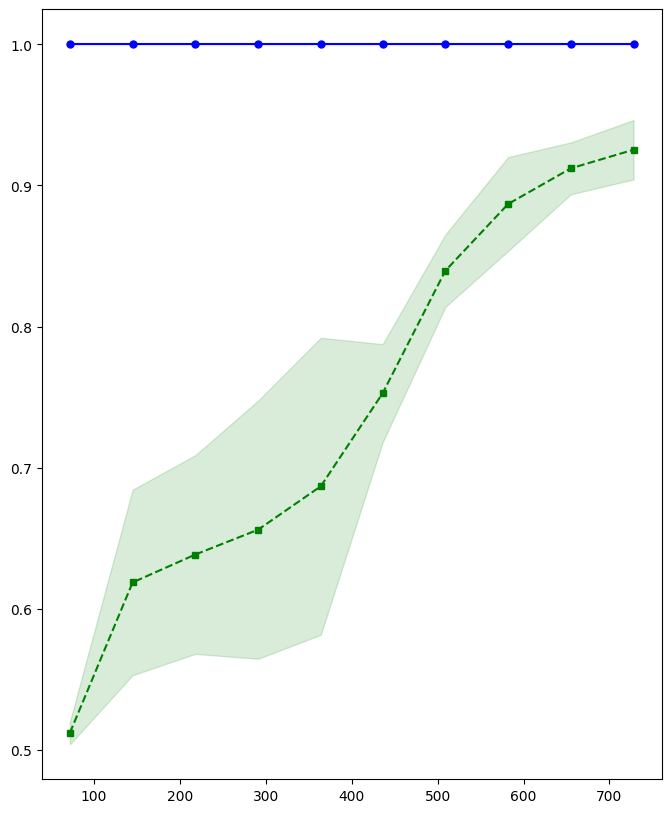

In [38]:
plot_learning_curve(rf, X_train, y_train)

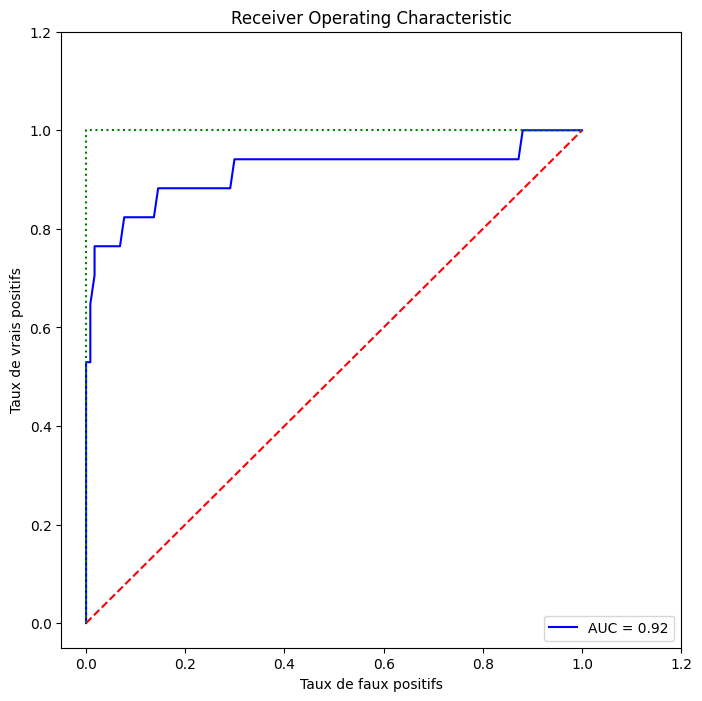

In [41]:
plot_roc_curve(rf,X_test,y_test)

## Extreme Gradient Boosting : XGBoost avec suréchantillonage SMOTE

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
print(xgb.score(X_test,y_test))

0.8955223880597015


In [43]:
y_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_xgb))

cm = metrics.confusion_matrix(y_test, y_xgb)
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       117
           1       0.57      0.71      0.63        17

    accuracy                           0.90       134
   macro avg       0.76      0.81      0.79       134
weighted avg       0.91      0.90      0.90       134

[[108   9]
 [  5  12]]


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/dist

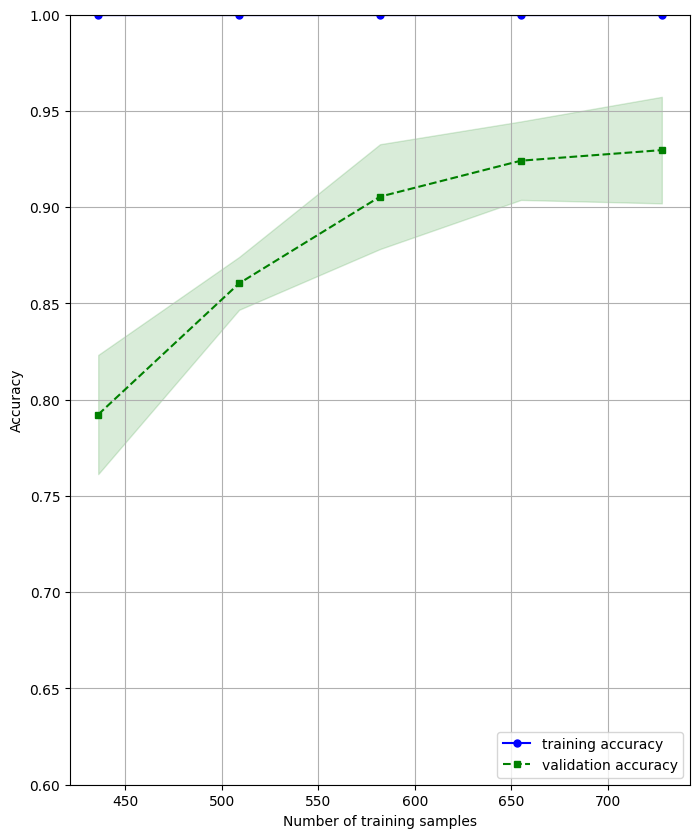

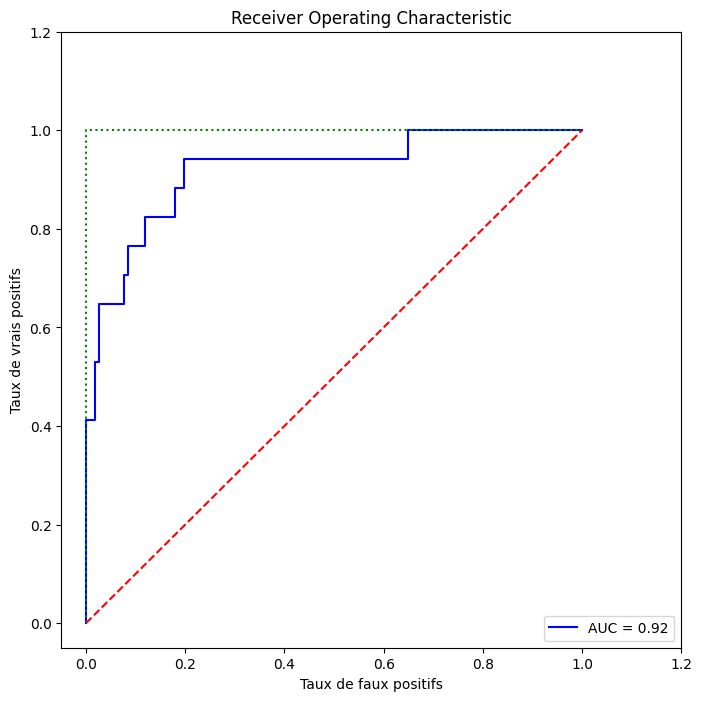

In [44]:
plot_learning_curve(xgb, X_train, y_train)
plot_roc_curve(xgb,X_test,y_test)

In [45]:
print(classification_report(y_test, y_xgb))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       117
           1       0.57      0.71      0.63        17

    accuracy                           0.90       134
   macro avg       0.76      0.81      0.79       134
weighted avg       0.91      0.90      0.90       134



## XGBoost pondéré

On va utiliser une amélioration de la méthode XGBoost, sans suréchantillonage

On reconstitue les jeux de données sans échantillonnage :

In [46]:
X = df.drop(['Churn'], axis=1)
y = df.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
df.Churn.value_counts()

,count
Churn,
0,572
1,95


On utilise le paramètre *scale_pos_weight* pour donner plus d'impact aux erreurs commises sur la classe minoritaire :

In [48]:
from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=2278/388)
# xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_xgb = xgb.predict(X_test)

In [49]:
print(classification_report(y_test, y_xgb))
cm = confusion_matrix(y_test, y_xgb)
print(cm)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       117
           1       0.72      0.76      0.74        17

    accuracy                           0.93       134
   macro avg       0.84      0.86      0.85       134
weighted avg       0.93      0.93      0.93       134

[[112   5]
 [  4  13]]


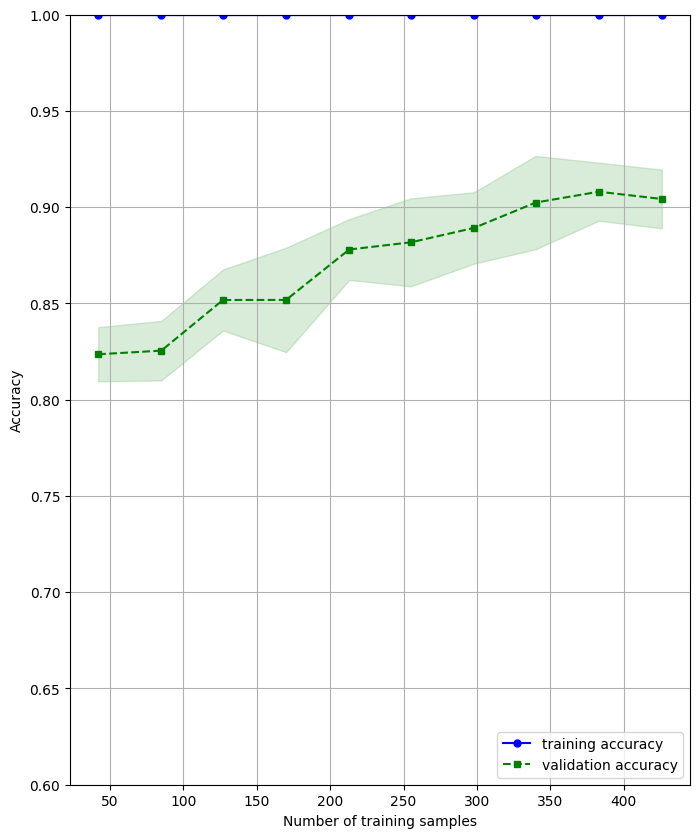

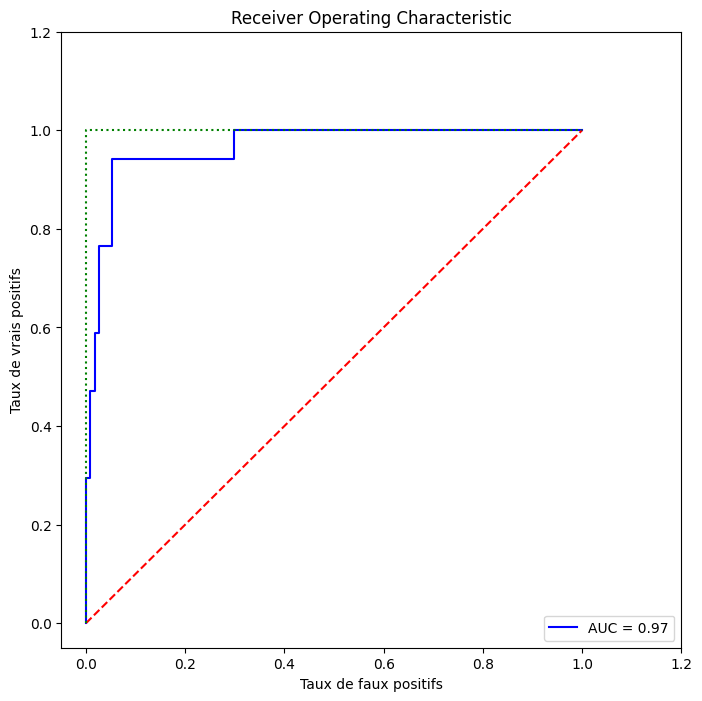

In [50]:
plot_learning_curve(xgb, X_train, y_train)
plot_roc_curve(xgb,X_test,y_test)

## Exercice : détection de fraude

Prédire les fraudes à la carte bancaire sur le dataset :  
https://www.kaggle.com/mlg-ulb/creditcardfraud

*Ces données contiennent les transactions effectuées par carte de crédit en septembre 2013 par les détenteurs de cartes européennes.
Cet ensemble de données présente les transactions qui ont eu lieu en deux jours, où nous avons 492 fraudes sur 284 807 transactions. L'ensemble de données est très déséquilibré, la classe positive (fraudes) représente 0,172 % de toutes les transactions.*

*Il ne contient que des variables d'entrée numériques qui sont le résultat d'une transformation ACP (analyse en composantes principales - une méthode de réduction de dimension). Malheureusement, pour des raisons de confidentialité, nous ne pouvons pas fournir les caractéristiques originales et plus d'informations sur le contexte des données. Les caractéristiques V1, V2, ... V28 sont les principales composantes obtenues avec l'ACP, les seules caractéristiques qui n'ont pas été transformées avec l'ACP sont "Temps" et "Montant". La caractéristique "Temps" contient les secondes écoulées entre chaque transaction et la première transaction de l'ensemble de données. La caractéristique "Montant" est le montant de la transaction, cette caractéristique peut être utilisée par exemple pour l'apprentissage dépendant des coûts. La caractéristique
"Class" est la variable de réponse et prend la valeur 1 en cas de fraude et 0 dans le cas contraire.*